# Quantum Kernel Machine Learning

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space, through the use of a kernel function:
$ k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle $
where $k$ is the kernel function, $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs, $f$ is a map from $n$-dimension to $m$-dimension space and $\langle a,b \rangle$ denotes the dot product. When considering finite data, a kernel function can be represented as a matrix: 
$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

In quantum kernel machine learning, a quantum feature map $\phi(\vec{x})$ is used to map a classical feature vector $\vec{x}$ to a quantum Hilbert space, $| \phi(\vec{x})\rangle \langle \phi(\vec{x})|$, such that $K_{ij} = \left| \langle \phi^\dagger(\vec{x}_j)| \phi(\vec{x}_i) \rangle \right|^{2}$. See [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf) for more details.

In this notebook, we use `qiskit` to calculate a kernel matrix using a quantum feature map, then use this kernel matrix in `scikit-learn` classification and clustering algorithms.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data, split_dataset_to_data_and_labels

seed = 12345
algorithm_globals.random_seed = seed

## Classification

For our classification example, we will use the _ad hoc dataset_ as described in [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf), and the `scikit-learn` [support vector machine](https://scikit-learn.org/stable/modules/svm.html) classification (`svc`) algorithm. 

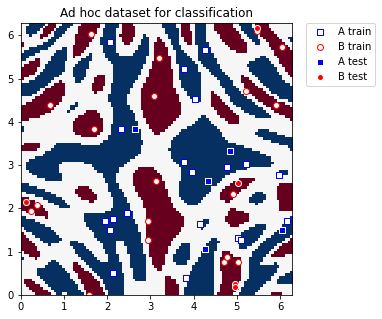

In [2]:
adhoc_dimension = 2
adhoc_total, adhoc_training, adhoc_testing, adhoc_classes = ad_hoc_data(
    training_size=20, 
    test_size=5, 
    n=adhoc_dimension, 
    gap=0.3, 
    plot_data=False
)

adhoc_train_data, _ = split_dataset_to_data_and_labels(adhoc_training)
adhoc_test_data, _ = split_dataset_to_data_and_labels(adhoc_testing)

plt.figure(figsize=(5,5)) 
plt.ylim(0,2*np.pi)
plt.xlim(0,2*np.pi)
plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest',
           origin='lower', cmap='RdBu', extent=[0, 2*np.pi, 0, 2*np.pi])
plt.scatter(adhoc_training['A'][:,0],adhoc_training['A'][:,1],
            marker='s', facecolors='w', edgecolors='b', label="A train")
plt.scatter(adhoc_training['B'][:,0],adhoc_training['B'][:,1],
            marker='o', facecolors='w', edgecolors='r', label="B train")
plt.scatter(adhoc_testing['A'][:,0],adhoc_testing['A'][:,1],
            marker='s', facecolors='b', edgecolors='w', label="A test")
plt.scatter(adhoc_testing['B'][:,0],adhoc_testing['B'][:,1],
            marker='o', facecolors='r', edgecolors='w', label="B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for classification")

plt.show()

With our training and testing datasets ready, we set up the [QuantumKernel]() class to calculate a kernel matrix using the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), and the `BasicAer` `qasm_simulator` using 1024 shots.

In [3]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, 
                                 reps=2, entanglement='linear')

adhoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)

adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

The `scikit-learn` `svc` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in `qiskit`.

The following code gives the kernel as a callable function:

In [4]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(adhoc_train_data[0], adhoc_train_data[1])
adhoc_score = adhoc_svc.score(adhoc_test_data[0], adhoc_test_data[1])

print(f'Callable kernel classification test score: {adhoc_score}')

Callable kernel classification test score: 1.0


The following code precomputes and plots the training and testing kernel matrices before providing them to the `scikit-learn` `svc` algorithm:

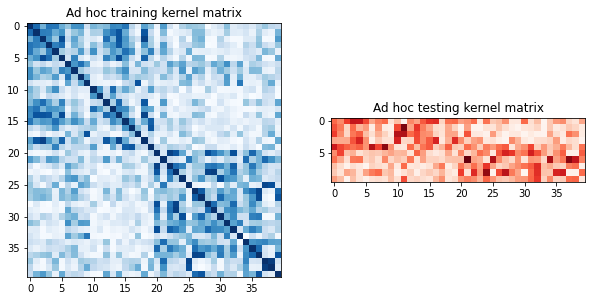

Precomputed kernel classiciation test score: 1.0


In [5]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=adhoc_train_data[0])
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=adhoc_test_data[0],
                                          y_vec=adhoc_train_data[0])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(adhoc_matrix_train),
              interpolation='nearest',origin='upper',cmap='Blues')
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(adhoc_matrix_test),
              interpolation='nearest',origin='upper',cmap='Reds')
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()

adhoc_svc = SVC(kernel='precomputed')
adhoc_svc.fit(adhoc_matrix_train, adhoc_train_data[1])
adhoc_score = adhoc_svc.score(adhoc_matrix_test, adhoc_test_data[1])

print(f'Precomputed kernel classiciation test score: {adhoc_score}')

`qiskit` also contains the `qsvc` class that extends the `sklearn svc` class, that can be used as follows:

In [ ]:
qsvc = QSVC(quantum_kernel=adhoc_kernel)
qsvc.fit(adhoc_train_data[0], adhoc_train_data[1])
qsvc_score = qsvc.score(adhoc_test_data[0], adhoc_test_data[1])

print(f'QSVC classification test score: {adhoc_score}')

## Clustering

For our clustering example, we will again use the _ad hoc dataset_ as described in [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf), and the `scikit-learn` [spectral]() clustering algorithm.

We will regenerate the dataset with a larger gap between the two classes, and as clustering is an unsupervised machine learning task, we don't need a test sample.

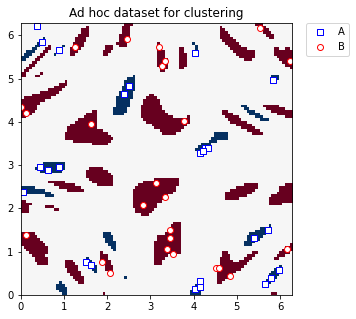

In [6]:
adhoc_dimension = 2
adhoc_total, adhoc_training, adhoc_testing, adhoc_classes = ad_hoc_data(
    training_size=25, 
    test_size=0, 
    n=adhoc_dimension, 
    gap=0.6, 
    plot_data=False
)

adhoc_data, _ = split_dataset_to_data_and_labels(adhoc_training)

plt.figure(figsize=(5,5)) 
plt.ylim(0,2*np.pi)
plt.xlim(0,2*np.pi)
plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest',
           origin='lower', cmap='RdBu', extent=[0, 2*np.pi, 0, 2*np.pi])
plt.scatter(adhoc_training['A'][:,0],adhoc_training['A'][:,1],
            marker='s', facecolors='w', edgecolors='b', label="A")
plt.scatter(adhoc_training['B'][:,0],adhoc_training['B'][:,1],
            marker='o', facecolors='w', edgecolors='r', label="B")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc dataset for clustering")

plt.show()

We again set up the [QuantumKernel]() class to calculate a kernel matrix using the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), and the BasicAer `qasm_simulator` using 1024 shots.

In [7]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, 
                                 reps=2, entanglement='linear')

adhoc_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)

adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

The scikit-learn spectral clustering algorithm allows us to define a [custom kernel] in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. Using the QuantumKernel class in qiskit, we can only use the latter.

The following code precomputes and plots the kernel matrices before providing it to the scikit-learn spectral clustering algorithm, and scoring the labels using normalized mutual information, since we apriori know the class labels.

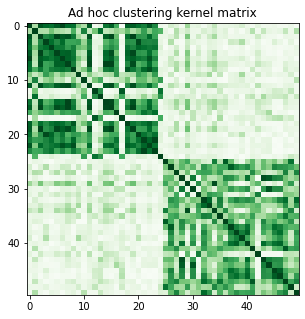

Clustering score: 0.7287008798015754


In [8]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=adhoc_data[0])

plt.figure(figsize=(5,5)) 
plt.imshow(np.asmatrix(adhoc_matrix),interpolation='nearest',origin='upper',cmap='Greens')
plt.title("Ad hoc clustering kernel matrix")
plt.show()

adhoc_spectral = SpectralClustering(2, affinity="precomputed")
cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)
cluster_score = normalized_mutual_info_score(cluster_labels, adhoc_data[1]) 

print(f'Clustering score: {cluster_score}')

`scikit-learn` has other algorithms that can use a precomputed kernel matrix, here are a few:

- [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
- [Support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
- [Guassian process regression](https://scikit-learn.org/stable/modules/gaussian_process.html)
- [Principal component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)


In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright